In [1]:
import utils
import matlab.engine
import dataset
import lstm_model
import importlib
cfg = utils.Config(
    num_rx_antennas=1,
    num_tx_antennas=32,
    num_subcarriers=80,
    train_test_split=0.8,
    data_root="../data/dataset1",
    reduce_pca_overhead=False,
    epochs=10,
    compression_rate_dct=0.6,
    predictor_window_size = 20,
    # total_bits=  @Ibrahim change the bits here
    # duplicate_data=1,
    # data_snr=-1
)


dataset.combine_time_series_paths(
    "../data/dataset2",
    list(range(33)),
    2.5e9,
    "train_set.pickle"
)
dataset.combine_time_series_paths(
    "../data/dataset2",
    list(range(34, 40)),
    2.5e9,
    "test_set.pickle"
)

train_set = dataset.dataset_from_path("../data/dataset2/train_set.pickle", cfg)
test_set = dataset.dataset_from_path("../data/dataset2/test_set.pickle", cfg)
matlab = matlab.engine.start_matlab()
refModel = lstm_model.FullLSTMModel(cfg, matlab)

Saving files to  ../data/dataset2\train_set.pickle
Number of samples (14320, 1, 32, 1, 80)
Saving files to  ../data/dataset2\test_set.pickle
Number of samples (2655, 1, 32, 1, 80)
This is the LSTM


In [2]:
refModel.fit(train_set)

Fitting the PCA
Fitting the LSTM
Epoch 1/10
893/893 [==============================] - 14s 13ms/step - loss: 0.0102
Epoch 2/10
893/893 [==============================] - 14s 16ms/step - loss: 0.0098
Epoch 3/10
893/893 [==============================] - 15s 16ms/step - loss: 0.0097
Epoch 4/10
893/893 [==============================] - 14s 15ms/step - loss: 0.0097
Epoch 5/10
893/893 [==============================] - 12s 14ms/step - loss: 0.0096
Epoch 6/10
893/893 [==============================] - 11s 12ms/step - loss: 0.0095
Epoch 7/10
893/893 [==============================] - 11s 13ms/step - loss: 0.0095
Epoch 8/10
893/893 [==============================] - 13s 14ms/step - loss: 0.0094
Epoch 9/10
893/893 [==============================] - 18s 21ms/step - loss: 0.0094
Epoch 10/10
447/447 [==============================] - 6s 12ms/step
DFT Compression: Preparing to compress to 250 coefficients


In [3]:
# Downlink
compressed_error, X_test = refModel.process(test_set)

# Uplink
predicted_csis, ul_pred_zdl = refModel.decode(compressed_error, X_test)

82/82 [==============================] - 1s 7ms/step
Predicted zdl: (2615, 500)
82/82 [==============================] - 0s 6ms/step
Predicted zdl: (2615, 500)
ul_pred_error: (2615, 500)


Assessing performance...
Plotting results...


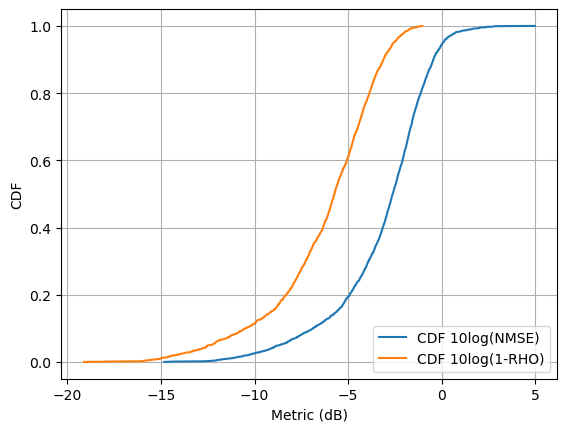

In [9]:
utils.reference_nmse_rho_test("lstm_plot", test_set.csi_samples[cfg.predictor_window_size:], predicted_csis,save_path = f"C:\\Users\ibrahimkilinc\Documents\ECE257_Project\\NonstaticCSI\simulation_results\data")

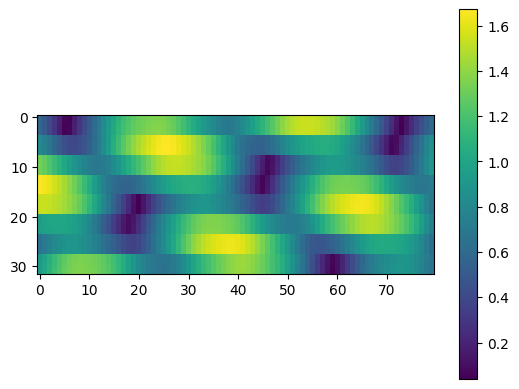

<Figure size 640x480 with 0 Axes>

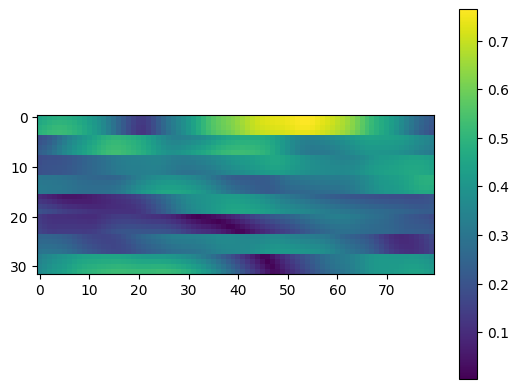

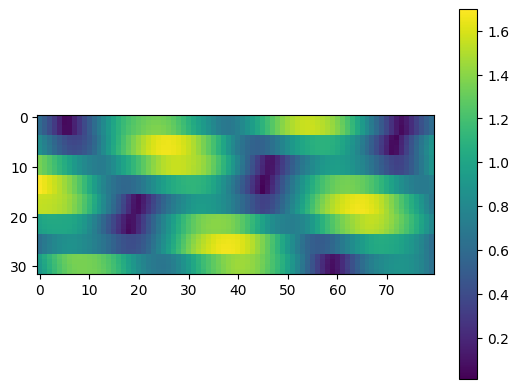

In [13]:
import matplotlib.pyplot as plt
import numpy as np

idx = 15

def plot_single_zdl(zdl, pca):
    plt.figure()
    zdl = np.expand_dims(zdl, axis=0)
    recovered = pca.decode(zdl)
    plt.imshow(np.squeeze(np.abs(recovered)))
    
plt.imshow(np.squeeze(np.abs(test_set.csi_samples[cfg.predictor_window_size + idx])))
plt.colorbar()
plt.figure()
plot_single_zdl(ul_pred_zdl[idx], refModel.pca)
plt.colorbar()

plt.figure()

plt.imshow(np.squeeze(np.abs(predicted_csis[idx])))
plt.colorbar()



## Pure DCT on Test Channels

In [30]:
from error_compression import reshape_tensor
from DCT_compression import DCTCompression
#load the dataset
# train_set, test_set = dataset.load_data(cfg)

cfg = utils.Config(
    num_rx_antennas=1,
    num_tx_antennas=32,
    num_subcarriers=80,
    train_test_split=0.8,
    data_root="../data/dataset1",
    reduce_pca_overhead=False,
    epochs=10,
    compression_rate_dct=0.997,
    # total_bits=  @Ibrahim change the bits here
    # duplicate_data=1,
    # data_snr=-1
)


csis = reshape_tensor(test_set.csi_samples , K=1)

compressor = DCTCompression(cfg, matlab)
compressor.fit(csis)
zdlcomp = compressor.process(csis)
predicted_csis = compressor.decode(zdlcomp)
predicted_csis = predicted_csis.reshape(test_set.csi_samples.shape)

DCT Compression: Preparing to compress to 7 coefficients


Assessing performance...
Plotting results...


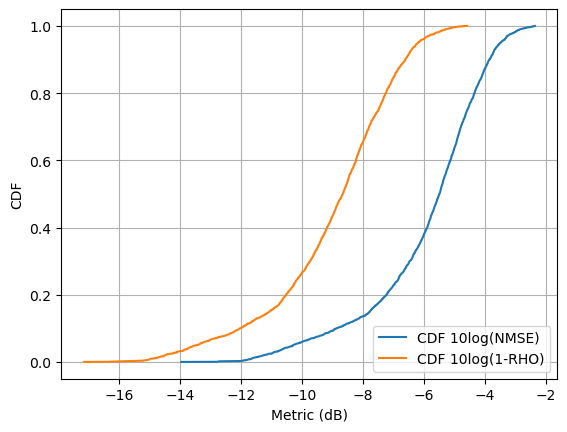

In [31]:
utils.reference_nmse_rho_test("lstm_plot", test_set.csi_samples, predicted_csis)